In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [7]:
@dataclass
class Dataset:
    raw_data: np.ndarray
    sampling_freq: int

# did this to make the code below work, think of it as a named tuple

In [3]:
# extracted code from gumpy, because some packages used create conflicts
# http://gumpy.org/
class ButterBandpass:
    """Filter class for a Butterworth bandpass filter.
    """

    def __init__(self, lowcut, highcut, order=8, fs=250):
        """Initialize the Butterworth bandpass filter.
        Args:
            lowcut (float): low cut-off frequency
            highcut (float): high cut-off frequency
            order (int): order of the Butterworth bandpass filter
            fs (int): sampling frequency
        """
        self.lowcut = lowcut
        self.highcut = highcut
        self.order = order

        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        self.b, self.a = signal.butter(order, [low, high], btype='bandpass')


    def process(self, data, axis=0):
        """Apply the filter to data along a given axis.
        Args:
            data (array_like): data to filter
            axis (int): along which data to filter
        Returns:
            ndarray: Result of the same shape as data
        """
        return signal.filtfilt(self.b, self.a, data, axis)



def butter_bandpass(data, lo, hi, axis=0, **kwargs):
    """Apply a Butterworth bandpass filter to some data.
    The function either takes an ``array_like`` object (e.g. numpy's ndarray) or
    an instance of a gumpy.data.Dataset subclass as first argument.
    Args:
        data (array_like or Dataset instance): input data. If this is an
            instance of a Dataset subclass, the sampling frequency will be extracted
            automatically.
        lo (float): low cutoff frequency.
        hi (float): high cutoff frequency.
        axis (int): along which axis of data the filter should be applied. Default = 0.
        **kwargs: Additional keyword arguments that will be passed to ``gumpy.signal.ButterBandstop``.
    Returns:
        array_like: data filtered long the specified axis.
    """
    if isinstance(data, Dataset):
        flt = ButterBandpass(lo, hi, fs=data.sampling_freq, **kwargs)
        filtered = [flt.process(data.raw_data[:, i], axis) for i in range(data.raw_data.shape[1])]
        reshaped = [f.reshape(-1, 1) for f in filtered]
        return np.hstack(reshaped)
    else:
        flt = ButterBandpass(lo, hi, **kwargs)
        return flt.process(data, axis)
class Notch:
    """Filter class for a notch filter.
    """

    def __init__(self, cutoff=50, Q=30, fs=250):
        """Initialize the notch filter.
        Args:
            cutoff (float): cut-off frequency. Default = 50.
            Q (float): Quality factor. Default = 30.
            fs (int): sampling frequency. Default = 250
        """
        self.cutoff = cutoff
        self.Q = Q

        nyq = 0.5 * fs
        w0 = cutoff / nyq
        self.b, self.a = signal.iirnotch(cutoff, Q, fs)


    def process(self, data, axis=0):
        """Apply the filter to data along a given axis.
        Args:
            data (array_like): data to filter
            axis (int): along which data to filter
        Returns:
            ndarray: Result of the same shape as data
        """
        return signal.filtfilt(self.b, self.a, data, axis)



def notch(data, cutoff, axis=0, **kwargs):
    """Apply a notch filter to data.
    The function either takes an ``array_like`` object (e.g. numpy's ndarray) or
    an instance of a gumpy.data.Dataset subclass as first argument.
    Args:
        data (array_like or Dataset instance): input data.
        cutoff (float): cutoff frequency. Default = 50.
        axis (int): along which axis of data the filter should be applied. Default = 0.
        Q (float): quality factor. Default = 30.
        fs (int): sampling frequenct. Default = 250.
    Returns:
        array_like: data filtered long the specified axis.
    """
    if isinstance(data, Dataset):
        flt = Notch(cutoff, fs=data.sampling_freq, **kwargs)
        filtered = [flt.process(data.raw_data[:, i], axis) for i in range(data.raw_data.shape[1])]
        reshaped = [f.reshape(-1, 1) for f in filtered]
        return np.hstack(reshaped)
    else:
        flt = Notch(cutoff, **kwargs)
        return flt.process(data, axis)


In [19]:
channels = ['ch'+str(i) for i in range(1,9)]
columns = channels + ['label']
data = pd.read_csv('../Quantum-BCI/experiments/OC_1/data.csv', header = None, names=columns)
data.head()
data = data[data.label != -1]
# discarded these values as mentioned by Satvik

I couldn't make Satvik's code work so I used code from gumpy and changed it accordingly.
My questions would be:
 - Is the bandpass filter correctly implemented?
 - How can I go from what I have down below to the alpha power data?
 - When I gave the low parameter 1 as in Satvik's code it gave a lot of NaN's, I changed it to 2 and it gives reasonable data, why is that?
 
 

# Notch filtering

Electrophysiological signals are often plagued with power line noise (50 or 60 Hz and harmonics) coupled electrically or magnetically with the recording circuits. While such noise is best eliminated at its source by careful equipment design and shielding, this is not always successful, nor is it applicable to data already gathered. Notch filtering is often used to mitigate such power line noise. Additional notches may be placed at harmonics if needed.

___cite___: https://www.sciencedirect.com/science/article/pii/S0896627319301746

In [20]:
ds = Dataset(raw_data = data.iloc[:,0:8].to_numpy(), sampling_freq=250)
ds_notched = notch(ds, cutoff=50, axis=0)
pd.DataFrame(ds_notched, columns=channels).head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,159313.862255,149452.945791,641298.171144,518620.127840,150391.967847,145761.987962,150766.818532,160436.143663
1,159309.213144,149452.039202,641258.656030,518575.564164,150440.825086,145783.862396,150775.779849,160427.951156
2,159297.941960,149395.702766,641166.548634,518511.842703,150336.789158,145744.219232,150712.073125,160266.821055
3,159284.814291,149359.372505,641098.021194,518475.408896,150240.676194,145694.647150,150659.454583,160187.471056
4,159290.376039,149387.364702,641091.917493,518478.443429,150255.647149,145697.507100,150678.982694,160265.679192


In [21]:
b_notch, a_notch = signal.iirnotch(50.0, 30.0, 250.0)
y_notched = signal.filtfilt(b_notch, a_notch, data.iloc[:,0:8], axis = 0)
pd.DataFrame(y_notched, columns=channels).head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,159313.862255,149452.945791,641298.171144,518620.127840,150391.967847,145761.987962,150766.818532,160436.143663
1,159309.213144,149452.039202,641258.656030,518575.564164,150440.825086,145783.862396,150775.779849,160427.951156
2,159297.941960,149395.702766,641166.548634,518511.842703,150336.789158,145744.219232,150712.073125,160266.821055
3,159284.814291,149359.372505,641098.021194,518475.408896,150240.676194,145694.647150,150659.454583,160187.471056
4,159290.376039,149387.364702,641091.917493,518478.443429,150255.647149,145697.507100,150678.982694,160265.679192


# Band-Pass Filtering

It has become traditional to interpret brain activity as coming from frequency bands with names such as alpha, beta, theta, etc., and data analysis often involves applying one or more band-pass filters to isolate particular bands, although the consensus is incomplete as to the boundary frequencies or the type of filter to apply.

___cite___: https://www.sciencedirect.com/science/article/pii/S0896627319301746

In [24]:
data_filtered = pd.DataFrame(butter_bandpass(ds_notched, lo=3, hi=30, axis=0), columns = channels)
data_filtered.head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,-0.445195,-1.336628,5.438246,3.364504,-3.207053,-1.244103,-1.722760,-4.397637
1,-7.991787,-23.323087,-15.596692,-15.070300,-32.969166,-13.045074,-25.044988,-63.849347
2,-13.829937,-40.126481,-31.526294,-29.164521,-56.275330,-22.524349,-44.048261,-109.852280
3,-16.806244,-48.437574,-38.939151,-36.036775,-68.935810,-28.112275,-55.746040,-133.812613
4,-16.643146,-47.869883,-37.286766,-35.228904,-70.287487,-29.419494,-59.272455,-134.686756


In [10]:
columns = ['power', 'tlab', 'glab']
data_alpha = pd.read_csv('../Quantum-BCI/experiments/OC_1/data_alpha.csv', header = None, names = columns)
data_alpha.head()

,power,tlab,glab
0,0.01642,0,-1
1,0.00279,0,-1
2,0.01018,0,-1
3,0.01897,0,-1
4,0.00843,0,-1


<AxesSubplot:>

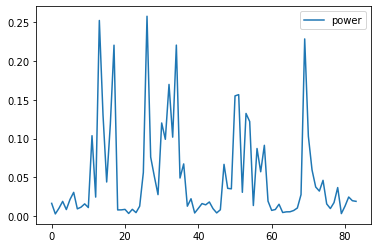

In [13]:
data_alpha.plot(y='power')

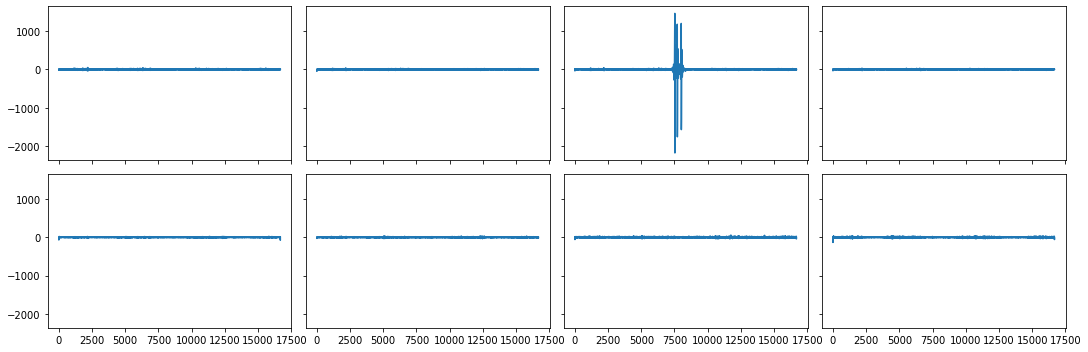

In [25]:
f, ax = plt.subplots(nrows=2,ncols=4, figsize=(15,5), sharey=True, sharex=True)
c = 0
for i in range(2):
    for j in range(4):
        ax[i,j].plot(data_filtered[columns[c]])
        c += 1
plt.tight_layout()